# Baseline: From OneR to Random Forests

A decision trees from-scratch treatment for tabular data using the [Identify Age-Related Conditions][0] kaggle competition.

Start by importing commonly used modules that make it convenient to work with the fastai library. Some will be patched to make them work in non-standard ways but improve interactivity.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions

In [1]:
from fastai.imports import *

## Data Processing

Get the dataset appropriately whether we're in kaggle or not. If in kaggle, it is assumed the competition dataset has been connected to the notebook.

In [2]:
import os
competition_name = "icr-identify-age-related-conditions"

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    path = Path(f"/kaggle/input/{competition_name}")
else:
    import zipfile, kaggle
    path = Path.home() / '.kaggle' / 'input' / competition_name
    kaggle.api.competition_download_cli(competition_name, path=path.parent)
    zipfile.ZipFile(f'{path}.zip').extractall(path)

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


Load the datasets.

In [3]:
path.ls()

(#4) [Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [4]:
df_train = pd.read_csv(f'{path}/train.csv')
df_test = pd.read_csv(f'{path}/test.csv')
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


We can now examine the data.

In [5]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


We see that the mean of the dependant column `Class` is much closer to zero than one. This means that the observations with a positive diagnosis are smaller in proportion in the training data. We confirm this by plotting a pie chart for column `Class`.

<Axes: ylabel='count'>

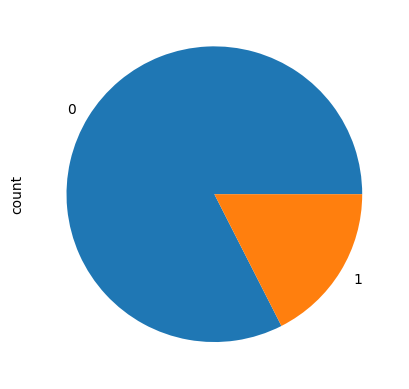

In [6]:
%matplotlib inline

df_train.Class.value_counts().plot.pie()

We also check for null values

In [7]:
df_train.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

We'll only do simple data processing. On the completition's data tab, we're informed that all columns are numeric  with the exception of EJ, which is categorical. We'll replace null values with modes, and convert EJ to a pandas categorical column.

In [9]:
modes = df_train.mode().iloc[0]

In [10]:

def process_data(df):
    df.fillna(modes, inplace=True)
    df["EJ"] = pd.Categorical(df.EJ)
    
process_data(df_train)
process_data(df_test)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Id      617 non-null    object  
 1   AB      617 non-null    float64 
 2   AF      617 non-null    float64 
 3   AH      617 non-null    float64 
 4   AM      617 non-null    float64 
 5   AR      617 non-null    float64 
 6   AX      617 non-null    float64 
 7   AY      617 non-null    float64 
 8   AZ      617 non-null    float64 
 9   BC      617 non-null    float64 
 10  BD      617 non-null    float64 
 11  BN      617 non-null    float64 
 12  BP      617 non-null    float64 
 13  BQ      617 non-null    float64 
 14  BR      617 non-null    float64 
 15  BZ      617 non-null    float64 
 16  CB      617 non-null    float64 
 17  CC      617 non-null    float64 
 18  CD      617 non-null    float64 
 19  CF      617 non-null    float64 
 20  CH      617 non-null    float64 
 21  CL      617 non-

A decision tree only requires that the column values can be ordered numerically.

For the categorical column EJ, we'll use the underlying categorical codes as its values.

In [12]:
df_train.EJ.head(), df_train.EJ.cat.codes.head()

(0    B
 1    A
 2    B
 3    B
 4    B
 Name: EJ, dtype: category
 Categories (2, object): ['A', 'B'],
 0    1
 1    0
 2    1
 3    1
 4    1
 dtype: int8)

Separately identify the categorical, numeric and dependent variables

In [13]:
categoricals = ["EJ"]
dependent = "Class"
conts = [column for column in df_train.columns if not column in categoricals + [dependent] + ["Id"]]

## Binary Splits

A decision tree is build on binary splits i.e. using the value of a column to split the rows into two groups. Let's use a barplot and countplot to analyse how splitting on EJ relates to the diagnosed class.

[Text(0.5, 1.0, 'Histogram')]

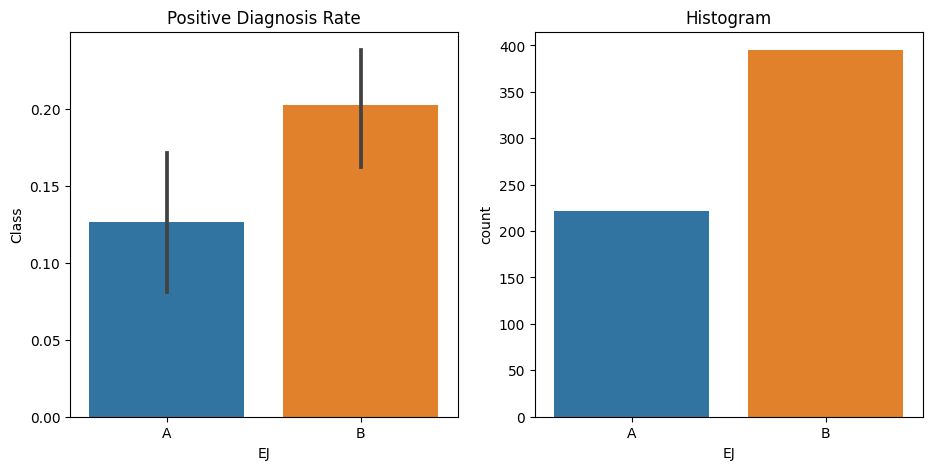

In [14]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
sns.barplot(data=df_train, y=dependent, x="EJ", ax=axs[0]).set(title="Positive Diagnosis Rate")
sns.countplot(data=df_train, x="EJ", ax=axs[1]).set(title="Histogram")

We have a higher positivity rate for category B (~ 20%) than category A (~ 3%). We also have much higher proportion of observations with category B (~ 400) than category A (~ 230). This correlation could in part explain why B has a higher positivity rate.

We can also do a split based on a continuous column. We'll go with column `AB` just for demonstration purposes. We use a boxplot to compare the averages of both positive and negative diagnosis based on the trait `AB` and a density plot to visualize the distribution of observations on `AB`.

<Axes: xlabel='AB', ylabel='Density'>

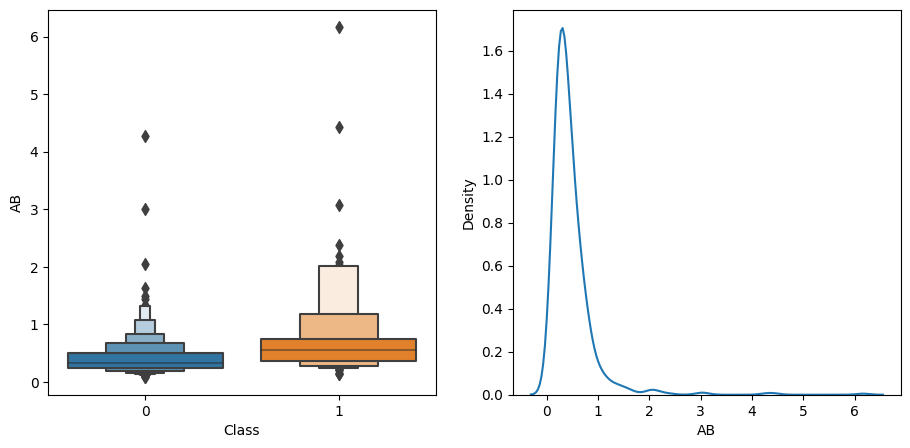

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
sns.boxenplot(data=df_train, x=dependent, y="AB", ax=ax1)
sns.kdeplot(data=df_train, x="AB", ax=ax2)

What we see is that the observations that result in a positive diagnosis have a slightly higher average of value `AB` than those that don't. We also notice that there some outliers with higher values for `AB`. It is difficult to determine the value of `AB` that best splits between the two classes though, since most of the observations are between 0 and 1 for `AB`, although the average value of negative diagnosis (class 0) appears below 0.5.

Since we have quite a number of columns, it would be tedious to plot each of them and figure out how well it partitions between positive and negative diagnosis, and which value of that column gives the best split.

We can however create a function that will help us quickly evaluate different splits by calculating a measure of impurity of how a split divides the observations into 2 groups, i.e. how (dis)similar they are with respect to the dependent variable.

We'll measure similarity by calculating the standard deviation of the dependent variable within each group of the split. The lower it is, they more similar the observations in each group are. We'll multiply this by the number of observations in each group since the bigger the group, they more weight it has.

We'll calculate the score of a split by summing the scores of the left side and the right side of that split using a particular value of that column.

In [16]:
def score(col, y, split_value):
    lhs = col <= split_value
    return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

def _side_score(side, y):
    count = side.sum()
    if count <=1: return 0
    return y[side].std() * count

For instance, the score based on value 0.5 for columns `AB`:

In [17]:
score(df_train.AB, df_train[dependent], 0.5)

0.36017711175753037

For the categorical column, we'd need to replace the column string values with their underlying codes, since we're splitting using numeric values.


In [18]:
df_train_n = df_train.copy()
df_train_n[categoricals] = df_train_n[categoricals].apply(lambda x: x.cat.codes)
df_train_n[categoricals].head()

,EJ
0,1
1,0
2,1
3,1
4,1


We then calculate the score using <= 1 as our split

In [19]:
score(df_train_n.EJ, df_train_n[dependent], 1)

0.3803100751041243

Looks like the split on the categorical is a bit worse than that of column `AB`.

To help us find the best split point, we'll iterate through the columns, and for each, we iterate through it's unique values to find the best split point for the column.

For example to find the best split point for column `AB`:

In [20]:
col = df_train_n["AB"]
y = df_train_n[dependent]
uniques = col.unique()
uniques.sort()
uniques[:50]

array([0.081187 , 0.08546  , 0.098279 , 0.102552 , 0.111098 , 0.119644 ,
       0.1217805, 0.1303265, 0.132463 , 0.136736 , 0.141009 , 0.145282 ,
       0.149555 , 0.153828 , 0.1559645, 0.158101 , 0.1602375, 0.162374 ,
       0.166647 , 0.17092  , 0.175193 , 0.179466 , 0.183739 , 0.1858755,
       0.188012 , 0.1901485, 0.192285 , 0.196558 , 0.200831 , 0.2029675,
       0.205104 , 0.209377 , 0.21365  , 0.217923 , 0.222196 , 0.2243325,
       0.226469 , 0.230742 , 0.235015 , 0.239288 , 0.243561 , 0.247834 ,
       0.252107 , 0.25638  , 0.260653 , 0.2627895, 0.264926 , 0.269199 ,
       0.2713355, 0.273472 ])

In [21]:
scores = np.array([score(col, y, split) for split in uniques])
uniques[scores.argmin()]

0.410208

This tells us that the value of `AB` that gives the best split is 0.410208.

Let's implement this idea to calculate the best split point for any given column.

In [22]:
def min_column(df, col_name):
    col, y = df[col_name], df[dependent]
    uniques = col.unique()
    scores = np.array([score(col, y, split) for split in uniques])
    index = scores.argmin()
    return uniques[index], scores[index]

In [23]:
min_column(df_train_n, "AB")

(0.410208, 0.3561906829723693)

We then try the same thing for the categorical variable:

In [24]:
min_column(df_train_n, "EJ")

(0, 0.3773339803468088)

Turns out having all observations on one side gives a better score when looking at the categorical column alone.

We then calculate the best split points for each of the columns to find the best split overall.

In [25]:
columns = conts + categoricals
splits = {col: min_column(df_train_n, col) for col in columns}

In [26]:
splits

{'AB': (0.410208, 0.3561906829723693),
 'AF': (2808.64232, 0.35583548065304915),
 'AH': (193.801377, 0.3761985927636321),
 'AM': (149.318758, 0.367338331639673),
 'AR': (16.327194, 0.3678281215243884),
 'AX': (17.877462, 0.37677322461475915),
 'AY': (0.6019965, 0.37677322461475915),
 'AZ': (10.971782, 0.3782810033906922),
 'BC': (13.500788, 0.35968813799570454),
 'BD ': (12083.34891, 0.3749922782916859),
 'BN': (21.186, 0.3651185274145938),
 'BP': (196.710795, 0.3725348222558456),
 'BQ': (115.695865, 0.3668876611761174),
 'BR': (3466.745415, 0.374094640781585),
 'BZ': (2885.319798, 0.376211243844383),
 'CB': (13.32695, 0.37775055805021784),
 'CC': (0.5478777, 0.3665150807004323),
 'CD ': (85.955376, 0.3635292346687648),
 'CF': (1.8504485, 0.367406050093466),
 'CH': (0.016318, 0.3782672405025747),
 'CL': (1.24754, 0.37657306471010377),
 'CR': (0.527325, 0.35228611051878406),
 'CS': (62.2516675, 0.37277362672289577),
 'CU': (1.274427, 0.37534114864714596),
 'CW ': (35.67944, 0.3772898765

It is very tedious to visually identify the best split, so we'll write some code to find the best one i.e. the one with the minimum score.

In [27]:
min_score = 1
for k, v in splits.items():
    if v[1] < min_score:
        min_score = v[1]
        min_score_column = k
min_score_column, splits[min_score_column]        

('DU', (2.27601, 0.3207517917154871))

According to this, the column `DU` gives the best score at split point `2.27601` overall. We can make a simple model based off this approach. This will be a variant of what is called the [OneR](https://link.springer.com/article/10.1023/A:1022631118932) (One Rule) classifier.

Though it's already a small dataset, we'll go through the typicall process of carving out a small validation set to evaluate the model.

In [28]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
model_train, model_val = train_test_split(df_train_n,  test_size=0.25)

In [29]:
model_train.shape, model_val.shape

((462, 58), (155, 58))

We split each of training and validation sets to independent and dependent variables.

In [30]:
def x_y(df):
    return df[conts + categoricals], df[dependent]

model_train_x, model_train_y = x_y(model_train)
model_val_x, model_val_y = x_y(model_val)

We get the best split using our model's training set.

In [31]:
one_r_splits = {col: min_column(model_train, col) for col in model_train_x.columns}
one_r_splits

{'AB': (0.581128, 0.3500151266645586),
 'AF': (2807.2121, 0.3482960305933906),
 'AH': (196.117971, 0.37031622929971825),
 'AM': (113.124119, 0.3677805771621117),
 'AR': (15.870966, 0.36607803019531715),
 'AX': (17.877462, 0.3701715230565572),
 'AY': (0.038976, 0.372511904676532),
 'AZ': (23.626198, 0.3735437010139049),
 'BC': (13.500788, 0.35865783745331065),
 'BD ': (10563.27538, 0.37017152305655715),
 'BN': (20.8329, 0.36082123208699335),
 'BP': (282.245337, 0.36079488319104713),
 'BQ': (69.65249, 0.36180119785038894),
 'BR': (5161.327397, 0.36527011004085347),
 'BZ': (2885.319798, 0.36963503519601426),
 'CB': (12.931737, 0.37244503925274197),
 'CC': (0.61375644, 0.3617285103240913),
 'CD ': (85.68186, 0.3631411826566342),
 'CF': (1.8504485, 0.36160897217069404),
 'CH': (0.012338, 0.3725637613110524),
 'CL': (1.24754, 0.3725459888575431),
 'CR': (0.527325, 0.34941117879168376),
 'CS': (62.2516675, 0.3671272819598272),
 'CU': (1.125468, 0.366462462615929),
 'CW ': (35.67944, 0.3672847

In [32]:
def get_best_split(splits):
    min_score = 1
    for k, v in splits.items():
        if v[1] < min_score:
            min_score = v[1]
            min_score_column = k
    return min_score_column, splits[min_score_column]

column, split = get_best_split(one_r_splits)
column, split

('DU', (2.262216, 0.3196074664465314))

According to this, `DU` still remains the best split at split point `2.262216`. We then use this as a simple OneR model and make predictions for the validation set.

In [33]:
preds = model_val_x["DU"] <= 2.262216

From this we can calculate the mean absolute error just to see how off the predictions are from the actual values in the validation set.

In [34]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(model_val_y, preds)

0.864516129032258

The error is relatively large suggesting that this baseline model is very inaccurate, meaning OneR works poorly for this data.

The competition defines the metric used to evaluate submissions [here][1]. I've copied the implementation from [this][2] comment in the discussion. The implementation details of this do not matter for our purposes. We just want to gauge the relative score as we go along.

[1]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview/evaluation
[2]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410864#2265438

In [35]:
def balanced_logarithmic_loss(y_true, y_pred):

    # Nc is the number of observations
    N_1 = np.sum(y_true == 1, axis=0)
    N_0 = np.sum(y_true == 0, axis=0)

    # In order to avoid the extremes of the log function, each predicted probability 𝑝 is replaced with max(min(𝑝,1−10−15),10−15)
    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)

    # balanced logarithmic loss
    loss_numerator = - (1/N_0) * np.sum((1 - y_true) * np.log(1-y_pred)) - (1/N_1) * np.sum(y_true * np.log(y_pred))

    return loss_numerator / 2

balanced_logarithmic_loss(model_val_y.to_numpy(), preds.to_numpy())

25.950508209640226

Our local score is 25.95. 

When submitted to the competition it had a leaderboard score of 25.97.

## Decision Tree

After having identified the best split for the training set we can split the data into two groups, then for each group, find the next best split.

We split our training data into two groups based on the value of `DU` we identified above then find the best successive splits.

In [36]:
lhs = model_train["DU"] <= 2.262216
left_group = model_train[lhs]
right_group = model_train[~lhs]
left_group.shape, right_group.shape

((396, 58), (66, 58))

Next, we find the best splits for each group while excluding the `DU` column.

In [37]:
second_level_columns = [c for c in (conts + categoricals) if c != "DU"]
left_splits = {col: min_column(left_group, col) for col in second_level_columns}
right_splits = {col: min_column(right_group, col) for col in second_level_columns}
left_splits, right_splits

({'AB': (0.363205, 0.2205227532918278),
  'AF': (1744.8442, 0.26422367520400314),
  'AH': (186.276801, 0.28281828339030296),
  'AM': (16.333578, 0.2678889313583875),
  'AR': (15.870966, 0.2866140712941824),
  'AX': (5.244528, 0.2773853964685262),
  'AY': (0.6019965, 0.2874443162878375),
  'AZ': (8.186298, 0.2851965412728709),
  'BC': (13.500788, 0.254228411937528),
  'BD ': (10563.27538, 0.28342483094474047),
  'BN': (15.1833, 0.2815221656802702),
  'BP': (318.7728, 0.27010283692431253),
  'BQ': (11.865775, 0.2794184862139197),
  'BR': (5161.327397, 0.2752096532354187),
  'BZ': (1703.832302, 0.28396363710150363),
  'CB': (12.931737, 0.28032816063022753),
  'CC': (0.61375644, 0.2699890428677908),
  'CD ': (88.048368, 0.2693262549530457),
  'CF': (2.548358, 0.27644641567153155),
  'CH': (0.016716, 0.2836102268644721),
  'CL': (1.152065, 0.2817474069769845),
  'CR': (0.6729, 0.25077109773069917),
  'CS': (55.8007175, 0.2831938474420979),
  'CU': (1.059264, 0.2763697098465586),
  'CW ': (4

In [38]:
best_left_split = get_best_split(left_splits)
best_right_split = get_best_split(right_splits)
best_left_split, best_right_split

(('AB', (0.363205, 0.2205227532918278)),
 ('GL', (0.047863636, 0.40470758822889663)))

For our left group, column `AB` results in the best split and `GL` for the right group.

Combining the three splitting rules by first splitting by `DU`, then the left group by `AB` and the right by `GL` results in a decision tree. Rather than rolling it out by hand, we can use sklearn's built in Decision Tree classifier.

In [39]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

model = DecisionTreeClassifier(max_leaf_nodes=4).fit(model_train_x, model_train_y)

We write a procedure to visualize the created tree.

In [40]:
import graphviz

def draw_tree(tree, df, size=10, ratio=0.6, precision=2, **kwargs):
    dot_format = export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                                special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', dot_format))

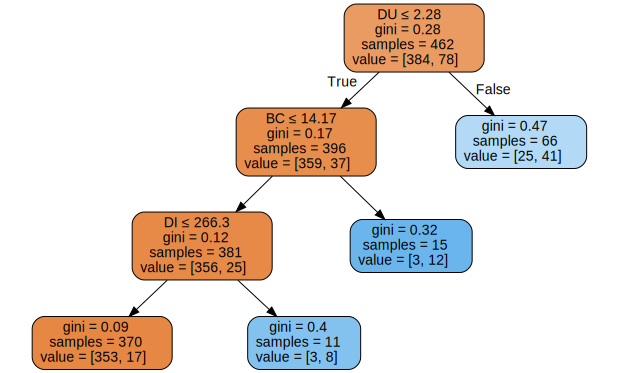

In [41]:
draw_tree(model, model_train_x, size=10)

The decision tree uses a measure of impurity called the gini index. This measures the probability that if one picks two observations from a group, they will not have the same value for the dependent column, i.e. the `Class` in our case. Therefore in the case of perfect classification, where all observations in the group have the same value for `Class`, the gini index is zero. The more impure the group is, the higher the gini index.

It is determined by subtracting the sum of squared probabilities of each class of the prediction from 1, and can be implemented as follows.

In [42]:
def gini(df, condition):
    actual = df.loc[condition, dependent]
    return 1 - actual.mean()**2 - (1-actual).mean()**2

We can replicate the split at the root of the tree above like so:

In [43]:
gini(model_train, model_train['DU'] <= 2.28), gini(model_train, model_train['DU'] > 2.28)

(0.16940873380267307, 0.47061524334251614)

Like with our OneR approach, the decision tree starts with a split on `DU` as the best split, thought it uses a different value for the split. Subsequent splits are different from what we got when we tried it by hand.

The non-leaf nodes show which column was used for the split and at what value, the gini score, the number of observations in that group prior to the split as `samples` and `value` hints at the purity of that group, showing how it is partitioned by the dependent variable.

We can calculate the mean absolute error of this decision tree:

In [44]:
preds = model.predict(model_val_x)
mean_absolute_error(model_val_y, preds)

0.11612903225806452

And also calculate the logloss metric:

In [45]:
balanced_logarithmic_loss(model_val_y.to_numpy(), preds)

5.549265256402579

We see that just two additional splits have increased the accuracy on the training data considerably.

We can create a bigger tree to see whether it will minimise the error further.

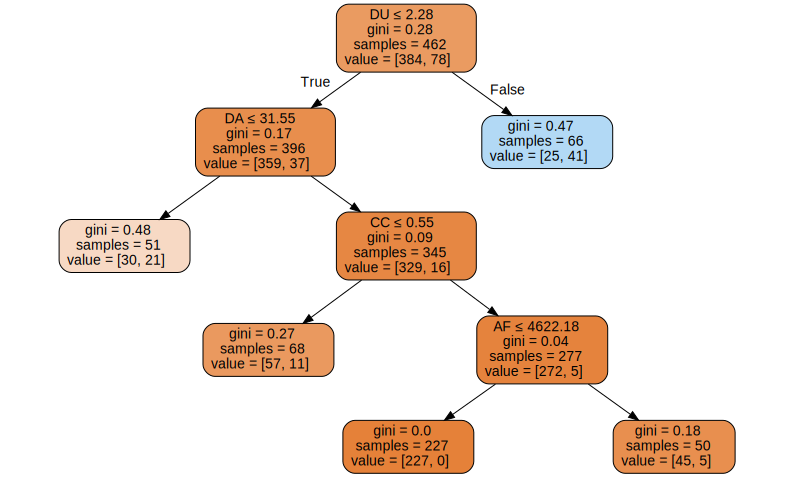

In [46]:
model = DecisionTreeClassifier(min_samples_leaf=50)
model.fit(model_train_x, model_train_y)
draw_tree(model, model_train_x, size=12)

By allowing the tree to have a greater number of leaf nodes, we've allowed it to reach a grouping with a gini score of zero, which is a perfect classification. However, the larger a decision tree is, the more it tends to overfit the training data and may not generalize well to the test data. 

We evaluate model as well:

In [47]:
preds = model.predict(model_val_x)

mean_absolute_error(model_val_y, preds), balanced_logarithmic_loss(model_val_y.to_numpy(), preds)

(0.12903225806451613, 8.450509680016193)

We find that it has a slightly higher error than the smaller tree maybe hinting at overfitting. When submitted to the competition, it had a score of 1.72 on the public leaderboard, an improvement over 25.97 of the OneR model.

## Random Forests

As mentioned, making the decision tree bigger will result in making it match the training data more closely, resulting in overfitting.

Instead of using bigger trees, we can use more trees. That's the insight from Leo Breiman who helped formulate the technique. By training more trees, each trained on a random uncorrelated subset of the training data and averaging their results, we get a better result because the average of uncorrelated errors is close to zero meaning the prediction is closer to the true value.

To demonstrate the technique, we can train a tree on a random subset of the data by:

In [48]:
def get_tree(proportion=0.75):
    n = len(model_train_y)
    indexes = random.choice(n, int(n*proportion))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(model_train_x.iloc[indexes], model_train_y.iloc[indexes])   

Now we can train as many trees as needed and average their results.

In [49]:
trees = [get_tree() for _ in range(100)]
trees[:5]

[DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5)]

In [50]:
all_preds = [t.predict(model_val_x) for t in trees]
avg_preds = np.stack(all_preds).mean(axis=0)

In [51]:
mean_absolute_error(model_val_y, avg_preds), balanced_logarithmic_loss(model_val_y.to_numpy(), avg_preds)

(0.1665806451612903, 0.4201347888809029)

The competition metric gives the best result yet of 0.42. This is the same score it received when submitted to the public leaderboard.

`sklearn`'s `RandomForestClassifier` does a similar process, but in addition to selecting a random subset of rows, it also selects a random subset of columns for each tree.

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
rf.fit(model_train_x, model_train_y)

preds =  rf.predict(model_val_x)


mean_absolute_error(model_val_y, preds), balanced_logarithmic_loss(model_val_y.to_numpy(), preds)

(0.05806451612903226, 5.180816459236603)

Although locally the score seems to be worse by the competition metric, on the public leaderboard it gave a score of 0.4, slightly better than the handrolled random forest approach.

The random forest model can also tell us which of the features were most important in making the predictions. We can plot the relevant feature importance as follows:

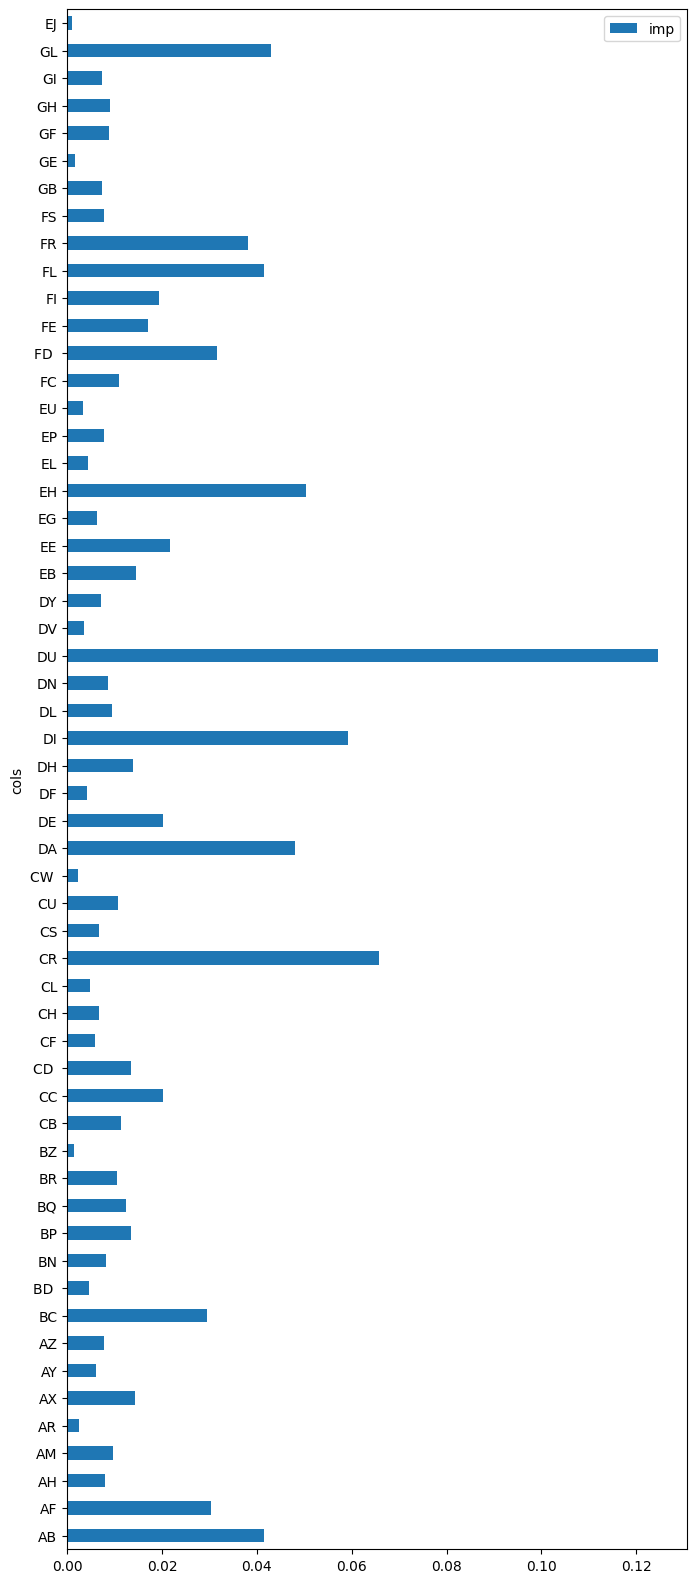

In [53]:
pd.DataFrame(dict(cols=model_train_x.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh', figsize=(8, 20));

From this, we can see that `DU` is the column that most heavily influences the final prediction. Since the data is anonymized, we cannot tell what trait `DU` represents but it seems to noticeably determine the outcome.

## Conclusion

In this notebook, we started with a very simple model, the [OneR model][3], that makes predictions based on just a single feature of the dataset. This kind of classifier was actually found to perform competitively with other machine learning methods of the early 90s.

We improved on the OneR model by performing splits based on several features instead of one, and thus implemented a decision tree. However, the bigger decision trees are, the more they tend to overfit training data.

Next, we saw how we could improve on a single decision tree by using many trees together working in an ensemble, each making predictions and then combining their results by averaging their predictions, which gave the best score yet.

However, there's still more that can be done to get better predictions for this competition. For example, since the training dataset is small, we can use [cross-validation][4] instead of using a single train/test split to get the model to generalize better. But for our purposes, we can conclude here. 


[3]: https://link.springer.com/article/10.1023/A:1022631118932
[4]: https://scikit-learn.org/stable/modules/cross_validation.html

Inspired  by Jeremy Howard's excellent notebook [here](https://www.kaggle.com/code/jhoward/how-random-forests-really-work/).